# Amazon Fine food reviews #

# Loading data

In [1]:
from sklearn.neighbors import NearestNeighbors
from matplotlib.colors import ListedColormap

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import sys

In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect("C:\\Users\\user\\Downloads\\amazon-fine-food-reviews\\database.sqlite") 

# tsne assignment take 5k data points
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1


#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)


Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [4]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [5]:
display['COUNT(*)'].sum()

393063

#  Exploratory Data Analysis: [Data Cleaning]: Deduplication

In [6]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [8]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

In [9]:
# observe that in some rows the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible
# hence remove them
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#number of entries left
print(final.shape)

# positive and negative reviews are present in dataset
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

# Preprocessing Review Text

In [10]:
# printing some random reviews
sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you don't like that combination, don't order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let's also remember that tastes differ; so, I've given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I don't see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They aren't individually wrapped, which would add to the cost.  Oh yeah, cho

In [11]:
# Combining all the above stundents 
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
from bs4 import BeautifulSoup

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

preprocessed_reviewssumm = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)  # remove urls from text python
    sentance = BeautifulSoup(sentance, 'lxml').get_text()  # remove all tags
    sentance = decontracted(sentance)     # replace english contractions
    sentance = re.sub("\S*\d\S*", "", sentance).strip()  #remove words with numbers python
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)  #remove spacial character
    sentance = ' '.join(token.lower() for token in nltk.word_tokenize(sentance) if token.lower() not in stopwords.words('english'))
    preprocessed_reviewssumm.append(sentance.strip())



100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:17<00:00, 279.48it/s]


In [12]:
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)  # remove urls from text python
    sentance = BeautifulSoup(sentance, 'lxml').get_text()  # remove all tags
    sentance = decontracted(sentance)     # replace english contractions
    sentance = re.sub("\S*\d\S*", "", sentance).strip()  #remove words with numbers python
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)  #remove spacial character
    sentance = ' '.join(token.lower() for token in nltk.word_tokenize(sentance) if token.lower() not in stopwords.words('english'))
    preprocessed_reviews.append(sentance.strip())


100%|██████████████████████████████████████████████████████████████████████████████| 4986/4986 [03:47<00:00, 21.87it/s]


In [13]:
# printing some random reviews
sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you don't like that combination, don't order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let's also remember that tastes differ; so, I've given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I don't see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They aren't individually wrapped, which would add to the cost.  Oh yeah, cho

In [14]:
preprocessed_reviewssumm[1500]

'reviewing mistakes cookies'

In [15]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies like combination order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however see taste like raw cookie dough soft however confusion yes stick together soft cookies tend individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

# Featurization: BAG OF WORDS

In [16]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12994)
the number of unique words  12994


# Bi-Grams, tri-gram and n-Grams.

In [17]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# take min_df=10, max_features=5000, acc to your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 2963)
the number of unique words including both unigrams and bigrams  2963


# TF-IDF

In [18]:
# tf-idf

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'according', 'acid']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 2963)
the number of unique words including both unigrams and bigrams  2963


# Word2Vec

In [19]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [20]:
train = True

if train:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))

[('excellent', 0.9970546364784241), ('snacking', 0.9965051412582397), ('think', 0.9960929155349731), ('overall', 0.9959701299667358), ('especially', 0.9959555864334106), ('bad', 0.9959232807159424), ('rather', 0.9958971738815308), ('amazing', 0.995887041091919), ('alternative', 0.9958752393722534), ('everyone', 0.9958490133285522)]
[('oh', 0.999420702457428), ('beef', 0.9994145631790161), ('varieties', 0.9993976354598999), ('wow', 0.9993541240692139), ('note', 0.9993135929107666), ('except', 0.9992930889129639), ('liked', 0.9992808103561401), ('experience', 0.9992777109146118), ('shot', 0.9992761611938477), ('fantastic', 0.999273955821991)]


In [21]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3814
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made', 'two']


# Avg W2v

In [22]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:08<00:00, 557.45it/s]


4986
50


In [23]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# TFIDF weighted W2v

In [24]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:55<00:00, 89.62it/s]


# Appling Naive Bayes on BOW

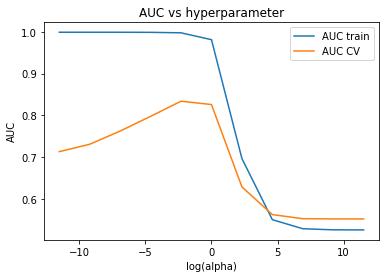

optimal alpha for which auc is maximum :  0.1


In [25]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection  import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection  import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import MultinomialNB
X=preprocessed_reviews

y=np.array(final['Score'])
count_vect=CountVectorizer()
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3)
final_Xtr=count_vect.fit_transform(X_tr)
final_Xcv=count_vect.transform(X_cv)
final_Xtest=count_vect.transform(X_test)
train_auc = []
cv_auc = []
alpha_values = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]#alpha from 10^-5 to 10^5
    
for i in alpha_values:
    mnb = MultinomialNB(alpha = i)
    mnb.fit(final_Xtr,y_tr)
    y_cv_pred=mnb.predict_proba(final_Xcv)[:,1]
    y_train_pred=mnb.predict_proba(final_Xtr)[:,1]
    train_auc.append(roc_auc_score(y_tr,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv,y_cv_pred))
    
optimal_alpha= alpha_values[cv_auc.index(max(cv_auc))]
alpha_values=[math.log(x) for x in alpha_values]

plt.plot(alpha_values, train_auc, label='AUC train')
plt.plot(alpha_values, cv_auc, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('log(alpha)')
plt.ylabel('AUC')
plt.legend()
plt.show()
print('optimal alpha for which auc is maximum : ',optimal_alpha)


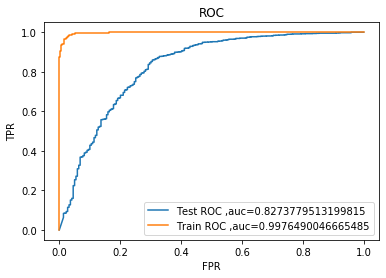

In [26]:
#ROC for alpha =0.1
mnb=MultinomialNB(alpha = 0.1)
mnb.fit(final_Xtr,y_tr)
predi=mnb.predict_proba(final_Xtest)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, predi)
pred=mnb.predict_proba(final_Xtr)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_tr,pred)

plt.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,predi)))
plt.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_tr,pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()


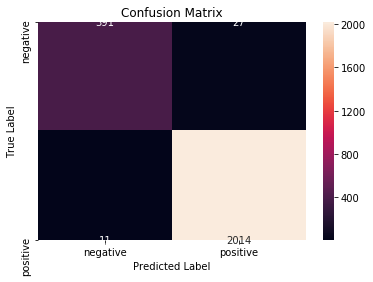

In [27]:
#confusion matrix using heatmap for train data
from sklearn.metrics import confusion_matrix
mnb=MultinomialNB(alpha=0.1)
mnb.fit(final_Xtr,y_tr)
predc=mnb.predict(final_Xtr)
import seaborn as sns
conf_mat = confusion_matrix(y_tr, predc)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

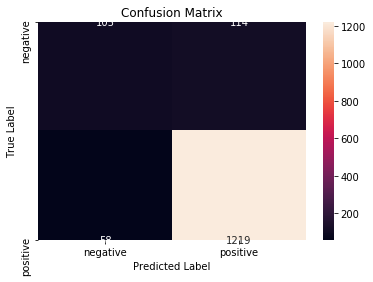

In [28]:
#Confusion matrix using heatmap for test data
from sklearn.metrics import confusion_matrix
mnb=MultinomialNB(alpha=0.1)
mnb.fit(final_Xtr,y_tr)
predic=mnb.predict(final_Xtest)
import seaborn as sns
conf_mat = confusion_matrix(y_test, predic)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Top 10 important features of positive class from BOW

In [29]:
model=MultinomialNB(alpha=0.1)
model.fit(final_Xtr,y_tr)
features = model.feature_log_prob_ #log probability of features
feature_names = count_vect.get_feature_names()
positive_features = np.argsort(features[1])[::-1]
negative_features = np.argsort(features[0])[::-1]
print("Top 10 important features of positive class from BOW")
for i in list(positive_features[0:10]):
    print(feature_names[i])


Top 10 important features of positive class from BOW
like
good
great
taste
one
love
coffee
would
flavor
product


# Top 10 important features of negative class from BOW

In [30]:
print("Top 10 important features of negavitive class from BOW")

for i in list(negative_features[0:10]):
    print(feature_names[i])

Top 10 important features of negavitive class from BOW
like
would
product
taste
one
tea
food
flavor
good
even


# Applying Naive Bayes on TFIDF

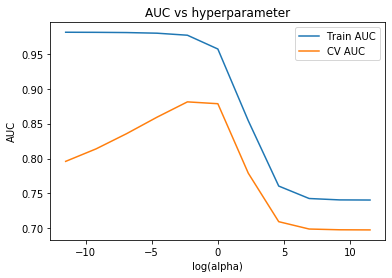

optimal alpha for which auc is maximum :  0.1


In [31]:
# tfidf 
X=preprocessed_reviews
y=np.array(final['Score'])

# split the data set into train and test
X_1, X_test, y_1, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = model_selection.train_test_split(X_1, y_1, test_size=0.3)

tf_idf_vect = TfidfVectorizer(min_df=10)
final_Xtr=tf_idf_vect.fit_transform(X_tr)
final_Xcv=tf_idf_vect.transform(X_cv)
final_Xtest=tf_idf_vect.transform(X_test)
auc_cv=[]
auc_tr=[]
k=[]

train_auc = []
cv_auc = []
alpha_values = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
    
for i in alpha_values:
    mnb = MultinomialNB(alpha = i)
    mnb.fit(final_Xtr,y_tr)
    y_train_pred =  mnb.predict_proba(final_Xtr)[:,1]
    y_cv_pred =  mnb.predict_proba(final_Xcv)[:,1]
    
    train_auc.append(roc_auc_score(y_tr,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
optimal_alpha= alpha_values[cv_auc.index(max(cv_auc))]
alpha_values=[math.log(x) for x in alpha_values]

plt.plot(alpha_values, train_auc, label='Train AUC')
plt.plot(alpha_values, cv_auc, label='CV AUC')
plt.legend()
plt.title('AUC vs hyperparameter')
plt.xlabel('log(alpha)')
plt.ylabel('AUC')
plt.show()

print('optimal alpha for which auc is maximum : ',optimal_alpha)


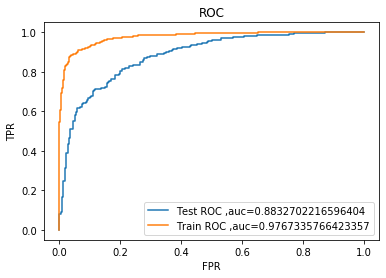

In [32]:
#ROC for alpha =0.1
mnb=MultinomialNB(alpha = 0.1)
mnb.fit(final_Xtr,y_tr)
predi=mnb.predict_proba(final_Xtest)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, predi)
pred=mnb.predict_proba(final_Xtr)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_tr,pred)

plt.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,predi)))
plt.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_tr,pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

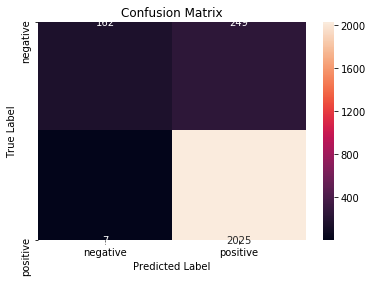

In [33]:
#confusion matrix using heatmap for train data
from sklearn.metrics import confusion_matrix
mnb=MultinomialNB(alpha=0.1)
mnb.fit(final_Xtr,y_tr)
predc=mnb.predict(final_Xtr)
import seaborn as sns
conf_mat = confusion_matrix(y_tr, predc)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

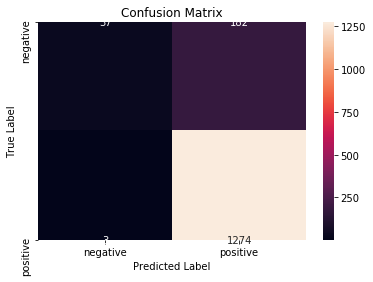

In [34]:
#confusion matrix using heatmap for test data
from sklearn.metrics import confusion_matrix
mnb=MultinomialNB(alpha=0.1)
mnb.fit(final_Xtr,y_tr)
predc=mnb.predict(final_Xtest)
import seaborn as sns
conf_mat = confusion_matrix(y_test, predc)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Top 10 important features of positive class from tfidf

In [35]:
model=MultinomialNB(alpha=0.1)
model.fit(final_Xtr,y_tr)
features = model.feature_log_prob_  #log probability of features
feature_names = tf_idf_vect.get_feature_names()
positive_features = np.argsort(features[1])[::-1]
negative_features = np.argsort(features[0])[::-1]
print("Top 10 important features of positive class from TFIDF")
for i in list(positive_features[0:10]):
    print(feature_names[i])

Top 10 important features of positive class from TFIDF
great
good
like
love
coffee
product
chips
taste
one
flavor


# Top 10 important features of negative class from BOW

In [36]:
print("Top 10 important features of negative class from TFIDF")
for i in list(negative_features[0:10]):
    print(feature_names[i])

Top 10 important features of negative class from TFIDF
like
taste
would
product
tea
flavor
food
chips
even
one


# Feature engineering

In [37]:
#Adding preprocessed summary and review length to preprocessed summary
for i in range(len(preprocessed_reviews)):
    preprocessed_reviews[i]+=' '+preprocessed_reviewssumm[i]+' '+str(len(final.Text.iloc[i]))

preprocessed_reviews[1500]

'wow far two two star reviews one obviously idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies like combination order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however see taste like raw cookie dough soft however confusion yes stick together soft cookies tend individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order reviewing mistakes cookies 1283'

# Applying Naive Bayes on BOW after feature engineering

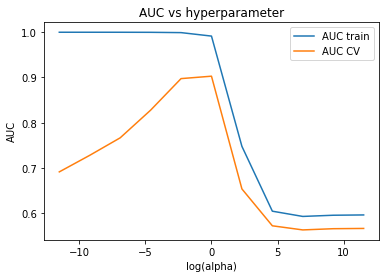

optimal alpha for which auc is maximum :  1


In [51]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection  import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection  import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import MultinomialNB
X=preprocessed_reviews

y=np.array(final['Score'])
count_vect=CountVectorizer()
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3)
final_Xtr=count_vect.fit_transform(X_tr)
final_Xcv=count_vect.transform(X_cv)
final_Xtest=count_vect.transform(X_test)
train_auc = []
cv_auc = []
alpha_values = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]#alpha from 10^-5 to 10^5
    
for i in alpha_values:
    mnb = MultinomialNB(alpha = i)
    mnb.fit(final_Xtr,y_tr)
    y_cv_pred=mnb.predict_proba(final_Xcv)[:,1]
    y_train_pred=mnb.predict_proba(final_Xtr)[:,1]
    train_auc.append(roc_auc_score(y_tr,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv,y_cv_pred))
    
optimal_alpha= alpha_values[cv_auc.index(max(cv_auc))]
alpha_values=[math.log(x) for x in alpha_values]

plt.plot(alpha_values, train_auc, label='AUC train')
plt.plot(alpha_values, cv_auc, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('log(alpha)')
plt.ylabel('AUC')
plt.legend()
plt.show()
print('optimal alpha for which auc is maximum : ',optimal_alpha)


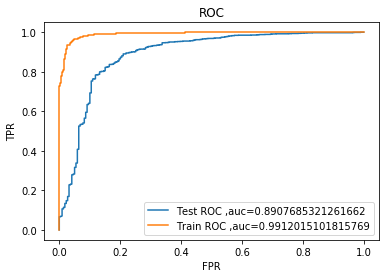

In [52]:
#ROC for alpha =1
mnb=MultinomialNB(alpha = 1)
mnb.fit(final_Xtr,y_tr)
predi=mnb.predict_proba(final_Xtest)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, predi)
pred=mnb.predict_proba(final_Xtr)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_tr,pred)

plt.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,predi)))
plt.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_tr,pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

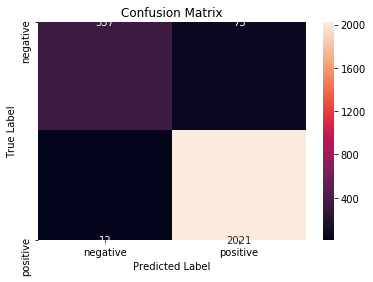

In [40]:
#confusion matrix using heatmap for train data
from sklearn.metrics import confusion_matrix
mnb=MultinomialNB(alpha=1)
mnb.fit(final_Xtr,y_tr)
predc=mnb.predict(final_Xtr)
import seaborn as sns
conf_mat = confusion_matrix(y_tr, predc)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

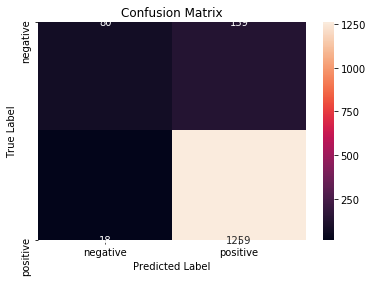

In [41]:
#Confusion matrix using heatmap for test data
from sklearn.metrics import confusion_matrix
mnb=MultinomialNB(alpha=1)
mnb.fit(final_Xtr,y_tr)
predic=mnb.predict(final_Xtest)
import seaborn as sns
conf_mat = confusion_matrix(y_test, predic)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Top 10 important features of positive class from BOW after feature engineering

In [42]:
model=MultinomialNB(alpha=1)
model.fit(final_Xtr,y_tr)
features = model.feature_log_prob_ #log probability of features
feature_names = count_vect.get_feature_names()
positive_features = np.argsort(features[1])[::-1]
negative_features = np.argsort(features[0])[::-1]
print("Top 10 important features of positive class from BOW")
for i in list(positive_features[0:10]):
    print(feature_names[i])

Top 10 important features of positive class from BOW
great
good
like
love
taste
best
one
product
flavor
coffee


# Top 10 important features of negative class from BOW after feature engineering

In [43]:
print("Top 10 important features of negative class from BOW")
for i in list(negative_features[0:10]):
    print(feature_names[i])

Top 10 important features of negative class from BOW
like
taste
would
product
flavor
one
good
food
even
chips


# Applying Naive Bayes on TFIDF after feature engineering

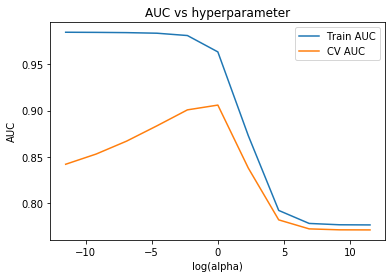

optimal alpha for which auc is maximum :  1


In [53]:
# tfidf 
X=preprocessed_reviews
y=np.array(final['Score'])

# split the data set into train and test
X_1, X_test, y_1, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = model_selection.train_test_split(X_1, y_1, test_size=0.3)

tf_idf_vect = TfidfVectorizer(min_df=10)
final_Xtr=tf_idf_vect.fit_transform(X_tr)
final_Xcv=tf_idf_vect.transform(X_cv)
final_Xtest=tf_idf_vect.transform(X_test)
auc_cv=[]
auc_tr=[]
k=[]

train_auc = []
cv_auc = []
alpha_values = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
    
for i in alpha_values:
    mnb = MultinomialNB(alpha = i)
    mnb.fit(final_Xtr,y_tr)
    y_train_pred =  mnb.predict_proba(final_Xtr)[:,1]
    y_cv_pred =  mnb.predict_proba(final_Xcv)[:,1]
    train_auc.append(roc_auc_score(y_tr,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
optimal_alpha= alpha_values[cv_auc.index(max(cv_auc))]
alpha_values=[math.log(x) for x in alpha_values]

plt.plot(alpha_values, train_auc, label='Train AUC')
plt.plot(alpha_values, cv_auc, label='CV AUC')
plt.legend()
plt.title('AUC vs hyperparameter')
plt.xlabel('log(alpha)')
plt.ylabel('AUC')
plt.show()

print('optimal alpha for which auc is maximum : ',optimal_alpha)


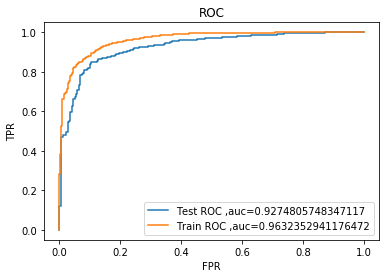

In [54]:
#ROC for alpha =1
mnb=MultinomialNB(alpha = 1)
mnb.fit(final_Xtr,y_tr)
predi=mnb.predict_proba(final_Xtest)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, predi)
pred=mnb.predict_proba(final_Xtr)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_tr,pred)

plt.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,predi)))
plt.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_tr,pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

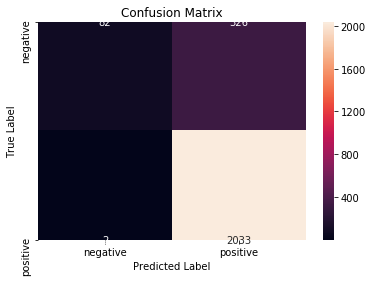

In [55]:
#confusion matrix using heatmap for train data
from sklearn.metrics import confusion_matrix
mnb=MultinomialNB(alpha=1)
mnb.fit(final_Xtr,y_tr)
predc=mnb.predict(final_Xtr)
import seaborn as sns
conf_mat = confusion_matrix(y_tr, predc)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

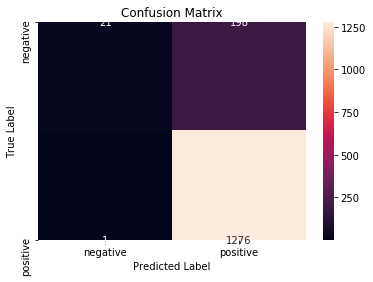

In [56]:
#confusion matrix using heatmap for test data
from sklearn.metrics import confusion_matrix
mnb=MultinomialNB(alpha=1)
mnb.fit(final_Xtr,y_tr)
predc=mnb.predict(final_Xtest)
import seaborn as sns
conf_mat = confusion_matrix(y_test, predc)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Top 10 important features of positive class from TFIDF after feature engineering

In [57]:
model=MultinomialNB(alpha=1)
model.fit(final_Xtr,y_tr)
features = model.feature_log_prob_  #log probability of features
feature_names = tf_idf_vect.get_feature_names()
positive_features = np.argsort(features[1])[::-1]
negative_features = np.argsort(features[0])[::-1]
print("Top 10 important features of positive class from TFIDF")
for i in list(positive_features[0:10]):
    print(feature_names[i])

Top 10 important features of positive class from TFIDF
great
good
love
coffee
like
chips
best
product
taste
tea


# Top 10 important features of negative class from TFIDF after feature engineering

In [58]:
print("Top 10 important features of negative class from TFIDF")
for i in list(negative_features[0:10]):
    print(feature_names[i])

Top 10 important features of negative class from TFIDF
like
would
taste
product
flavor
chips
tea
one
even
food


# conclusion

In [60]:

# Please compare all your models using Prettytable library
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Vectorizer", "Feature engineering", "Hyperameter(alpha)", "AUC"]
x.add_row(["BOW","Not featured",0.1,0.827])
x.add_row(["TFIDF","Not featured",0.1,0.883])

x.add_row(["BOW","Featured",0.1,0.890])
x.add_row(["TFIDF","Featured",1,0.927])

print(x)

+------------+---------------------+--------------------+-------+
| Vectorizer | Feature engineering | Hyperameter(alpha) |  AUC  |
+------------+---------------------+--------------------+-------+
|    BOW     |     Not featured    |        0.1         | 0.827 |
|   TFIDF    |     Not featured    |        0.1         | 0.883 |
|    BOW     |       Featured      |        0.1         |  0.89 |
|   TFIDF    |       Featured      |         1          | 0.927 |
+------------+---------------------+--------------------+-------+
